In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

tornado_data = '/content/drive/Shareddrives/MATH 3439 Work/project3-team4/data/model_data.csv'

Mounted at /content/drive


#Data Preparation

In [2]:
tornado_df_raw = pd.read_csv(tornado_data)

# Drop Unnecessary Rows and Columns
tornado_df = tornado_df_raw[tornado_df_raw['EF-Scale'] != -9]
tornado_df = tornado_df.drop(columns=['Unnamed: 0'])
tornado_df = tornado_df.drop(columns=['Unnamed: 0.1'])
tornado_df = tornado_df.drop(columns=['tornado_count'])
tornado_df = tornado_df.drop(columns=['decade'])

# Get Ranged Tornados (middle / violent / non violent) Based on Rating
tornado_ranged_df = pd.DataFrame()
tornado_ranged_df['middle_ranged'] = ((tornado_df['EF-Scale'] > 0) & (tornado_df['EF-Scale'] < 5)).astype(int)
tornado_ranged_df['violent_ranged'] = ((tornado_ranged_df['middle_ranged'] == 1) & (tornado_df['EF-Scale'] > 2)).astype(int)
tornado_ranged_df['non_violent_ranged'] = ((tornado_ranged_df['middle_ranged'] == 1) & (tornado_df['EF-Scale'] < 2)).astype(int)

pd.set_option('display.max_columns', None)
tornado_df

,year,month,day,date,time,time_zone,state,state_FIPS,stn,EF-Scale,injuries,fatalities,est_prop_loss,est_crop_loss,start_lat,start_long,end_lat,end_long,length(mi),width (yd),total_state_affected,state_num,tornado_segment,county_fips_1,county_fips_2,county_fips_3,county_fips_4,estimated_F-scale (2016)
0,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.7300,-102.5200,36.8800,-102.3000,15.80,10,1,1,1,25,0,0,0,0
1,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,3,1,0,5.0,0.0,40.2000,-76.1200,40.4000,-75.9300,15.90,100,1,1,1,71,11,0,0,0
2,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,2,3,1,4.0,0.0,38.9700,-90.0500,39.0700,-89.7200,18.80,50,1,1,1,119,117,0,0,0
3,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,3,25,2,6.0,0.0,38.7500,-89.6700,38.9000,-89.3800,18.00,200,1,1,1,119,5,0,0,0
4,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,3,0,0,1.0,0.0,36.1200,-91.8300,36.1800,-91.7200,7.80,10,1,1,1,65,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42329,2021,9,8,2021-09-08,15:32:00,3,PA,42,0,1,0,0,0.0,0.0,40.7586,-77.0062,40.7507,-76.9959,0.73,30,1,1,1,109,0,0,0,0
42330,2021,9,8,2021-09-08,15:35:00,3,PA,42,0,0,0,0,20000.0,0.0,40.7529,-76.9131,40.7561,-76.8878,1.45,30,1,1,1,109,0,0,0,0
42331,2021,9,8,2021-09-08,19:08:00,3,FL,12,0,0,0,0,0.0,0.0,30.1599,-84.4497,30.1775,-84.4629,1.45,50,1,1,1,129,0,0,0,0
42332,2021,9,9,2021-09-09,02:10:00,3,CT,9,0,0,0,0,40000.0,0.0,41.7500,-72.2990,41.7570,-72.2880,0.75,75,1,1,1,13,0,0,0,0


#Helper Functions

In [3]:
# Remove Null/NA Rows
#-----------------------------------------
def remove_null_rows(df, verbose=True):
    null_counts = df.isnull().sum()
    total_nulls = null_counts.sum()
    rows_with_nulls = df.isnull().any(axis=1).sum()

    if verbose:
        print("Null Value Summary:")
        print(f"Total null values: {total_nulls}")
        print(f"Rows with at least one null: {rows_with_nulls}")
        if total_nulls > 0:
            print("\nNull counts per column:")
            print(null_counts[null_counts > 0])
        else:
            print("No null values found in the DataFrame.")

    # Remove rows with any null values
    cleaned_df = df.dropna()

    if verbose:
        print(f"\nOriginal number of rows: {len(df)}")
        print(f"Rows after removing nulls: {len(cleaned_df)}")
        print(f"Rows removed: {len(df) - len(cleaned_df)}")

    return cleaned_df
#-----------------------------------------

# Get All Numeric Columns
#-----------------------------------------
def get_numeric_columns(df, exclude_columns=None):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_columns is not None:
        for col in exclude_columns:
            if col in numeric_cols:
                numeric_cols.remove(col)
    return numeric_cols
#-----------------------------------------

#Plot Prediction Scatter Plot
#-----------------------------------------
def build_pred_scatter_plot(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    #Plot Scatter Plot
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
            color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.show()
#-----------------------------------------

#Plot Prediction Confusion Matrix
#-----------------------------------------
from sklearn.metrics import confusion_matrix
def build_pred_confusion_matrix(y_test, y_pred, labels=None):
    plt.figure(figsize=(8, 6))
    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # Get Percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage,
                annot=True,
                fmt=".2f",
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.show()
#-----------------------------------------

#Correlation Graph

EF-Scale


<ipython-input-4-ee87e8f89504>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations['Correlation'], y=top_correlations['Feature'], palette=colors)


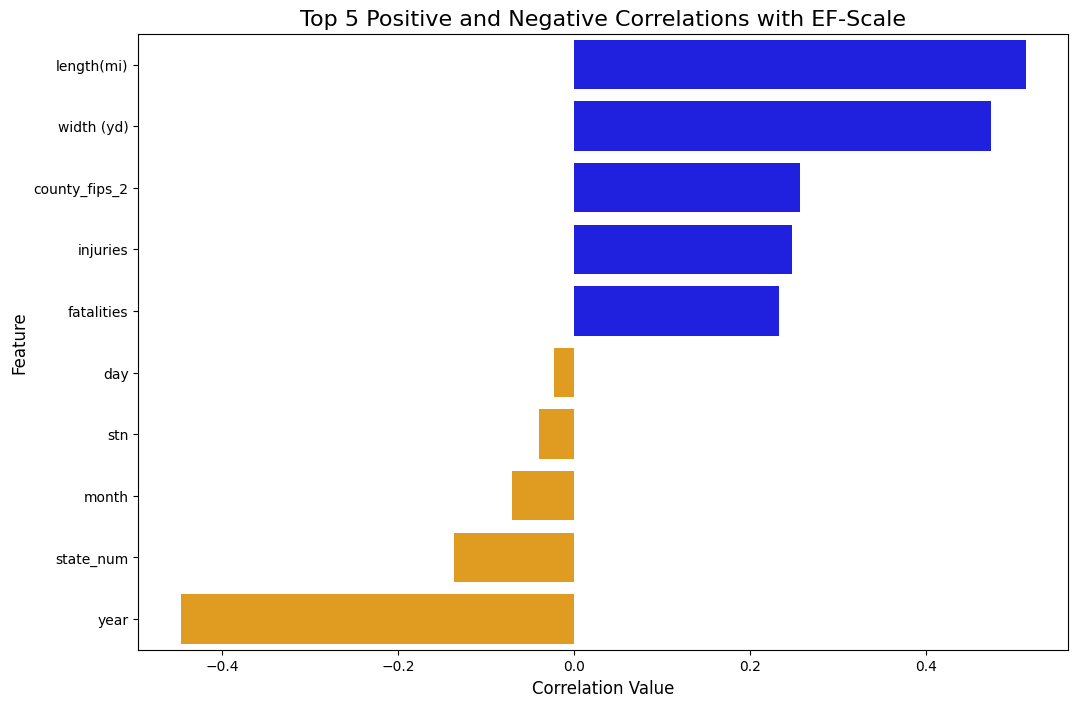

In [4]:
df = tornado_df
corr_items= ["EF-Scale"];

for corr_item in corr_items:
    print(corr_item)

    # Get numeric columns excluding the correlation item
    numeric_columns = get_numeric_columns(df, [corr_item])
    corr_values = []
    labels = []

    # Calculate correlations
    for column in numeric_columns:
        correlation_value = df[column].corr(df[corr_item])
        corr_values.append(round(correlation_value, 3))
        labels.append(column)  # Use just the column name for cleaner labels

    # Create DataFrame with features and correlations
    correlation_df = pd.DataFrame({'Feature': labels, 'Correlation': corr_values})

    # Separate positive and negative correlations
    positive_corr = correlation_df[correlation_df['Correlation'] > 0]
    negative_corr = correlation_df[correlation_df['Correlation'] < 0]

    # Get top 5 positive correlations
    top_positive = positive_corr.sort_values(by='Correlation', ascending=False).head(5)

    # Get top 5 negative correlations (most negative)
    top_negative = negative_corr.sort_values(by='Correlation', ascending=True).head(5)

    # Combine top positive and top negative
    top_correlations = pd.concat([top_positive, top_negative])

    #Sort by descending order
    top_correlations = top_correlations.sort_values(by='Correlation', ascending=False)

    # Create a color list based on the sign of the correlation
    colors = ['blue' if value >= 0 else 'orange' for value in top_correlations['Correlation']]

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_correlations['Correlation'], y=top_correlations['Feature'], palette=colors)

    # Add titles and labels
    plt.title(f"Top 5 Positive and Negative Correlations with {corr_item}", fontsize=16)
    plt.xlabel("Correlation Value", fontsize=12)
    plt.ylabel("Feature", fontsize=12)

    # Show the plot
    plt.show()

#Linear Regression

Predict: length(mi)
R² Score: 0.8886
Mean Squared Error (MSE): 13.4011
Mean Absolute Error (MAE): 1.5011


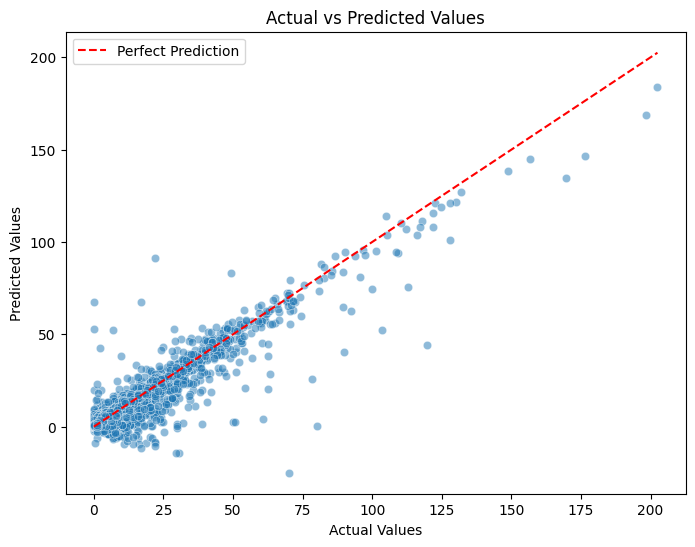

<ipython-input-4-132288f01590>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)


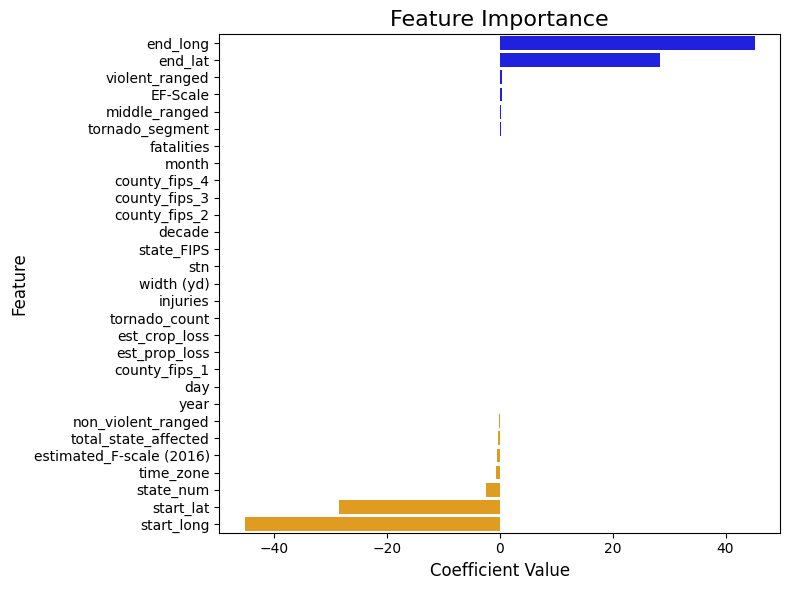

Predict: width (yd)
R² Score: 0.3053
Mean Squared Error (MSE): 47108.3123
Mean Absolute Error (MAE): 114.3996


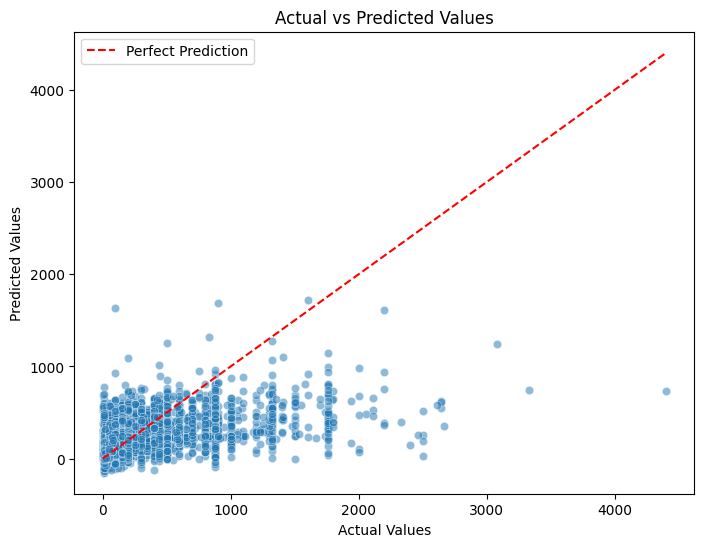

<ipython-input-4-132288f01590>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)


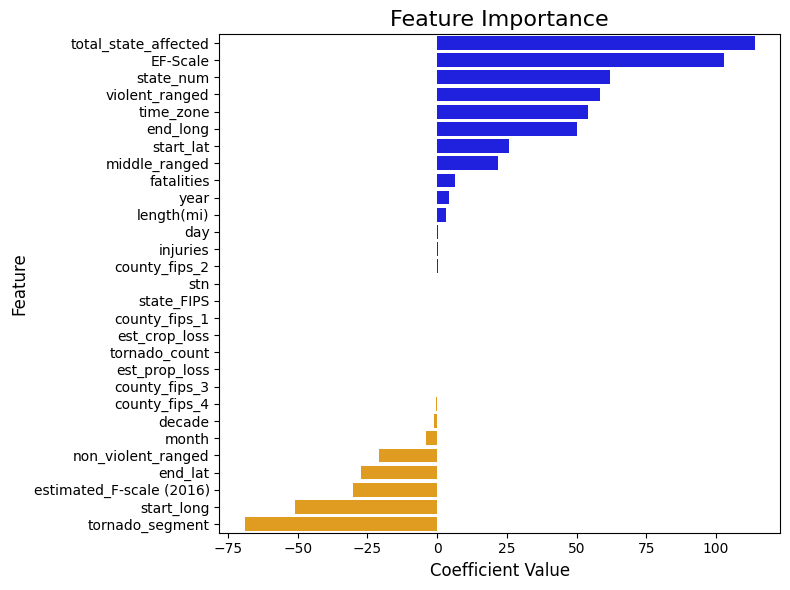

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

df = tornado_df
df_ranged = tornado_ranged_df
pred_items = ["length(mi)", "width (yd)"]

# Merge Dataframes
df_ranged.index = df.index
df = pd.merge(df, df_ranged, left_index=True, right_index=True, how='left')

for pred_item in pred_items:

  # Get Test / Training Data
  X = df[get_numeric_columns(df, [pred_item])]
  y = df[pred_item]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Linear Regression Model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Calculate Predictions / Metrics
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  # Show Model Info
  print(f"Predict: {pred_item}")
  print(f"R² Score: {r2:.4f}")
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")

  # Build Prediction Scatterplot
  build_pred_scatter_plot(y_test, y_pred)

  # Get Feature Names
  feature_names = X.columns.tolist()

  # Extract coefficients
  coef = model.coef_
  importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coef
  })

  # Sort by coefficient value
  importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

  # Colors: blue for positive, orange for negative
  colors = ['blue' if value >= 0 else 'orange' for value in importance_df['Coefficient']]

  # Create bar plot
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)
  plt.title(f"Feature Importance", fontsize=16)
  plt.xlabel("Coefficient Value", fontsize=12)
  plt.ylabel("Feature", fontsize=12)
  plt.tight_layout()
  plt.show()

#Decision Tree Heatmap / Gradiant Boosting

<Figure size 1200x600 with 0 Axes>

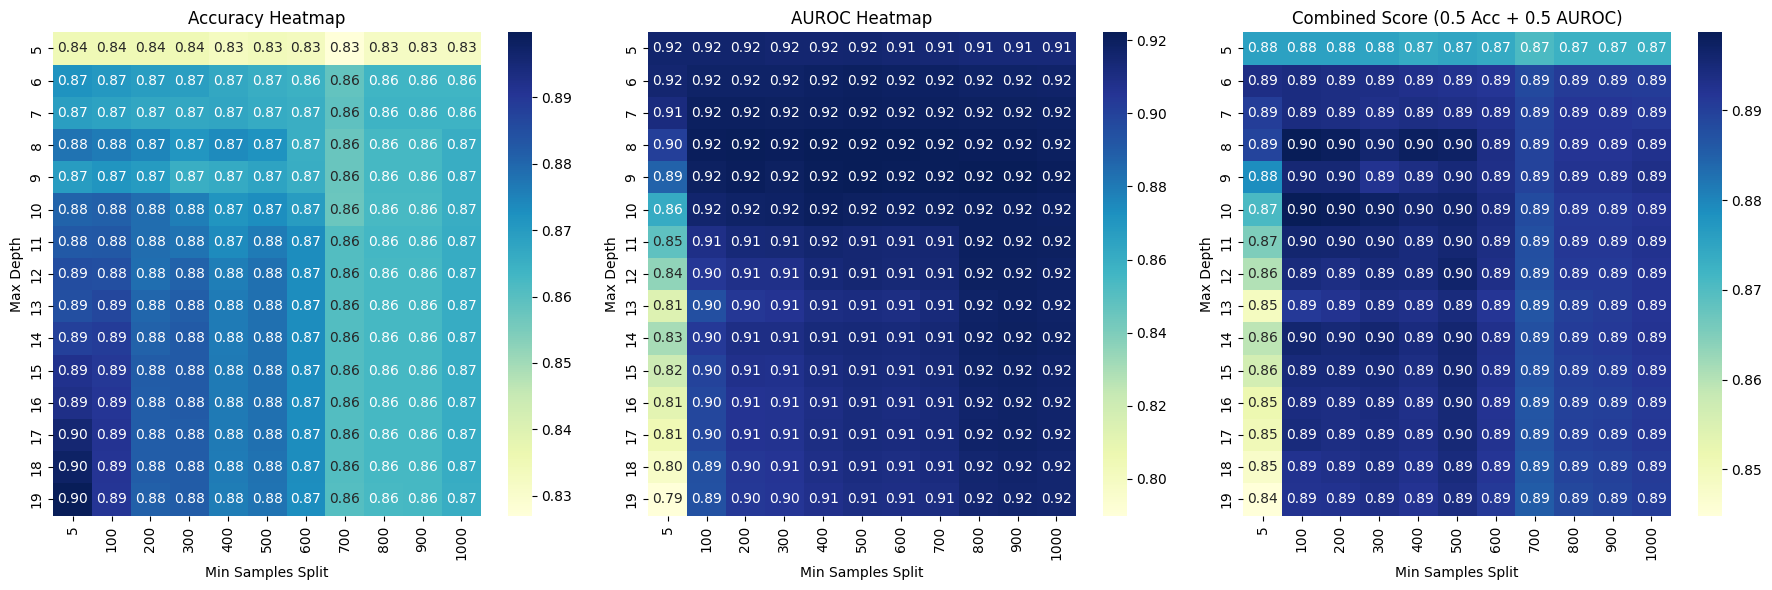


Best Performing Tree for violent_ranged (Combined Score):
Max Depth: 10
Min Samples Split: 100
Accuracy: 0.8812
AUROC: 0.9162
Combined Score: 0.8987


<Figure size 800x600 with 0 Axes>

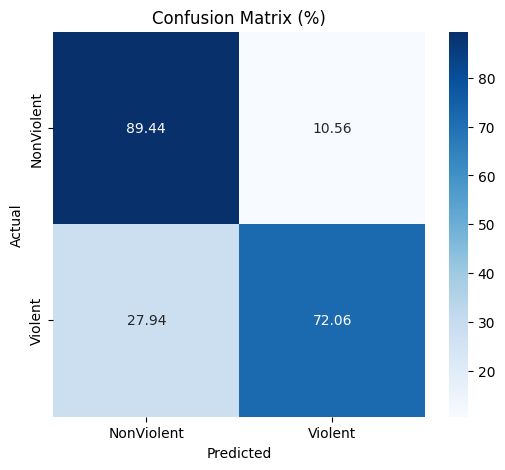


Gradient Boosting Classifier Performance for violent_ranged:
Accuracy: 0.8908
AUROC: 0.9335


<Figure size 800x600 with 0 Axes>

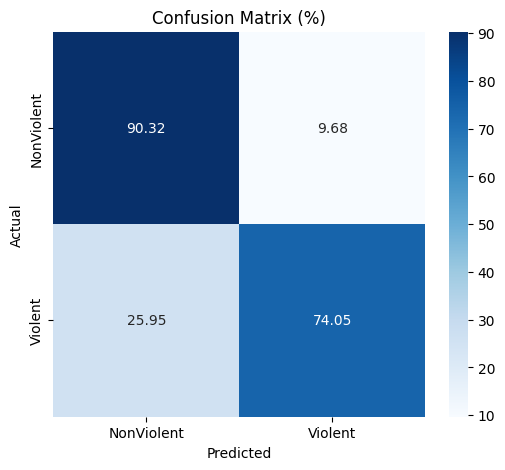

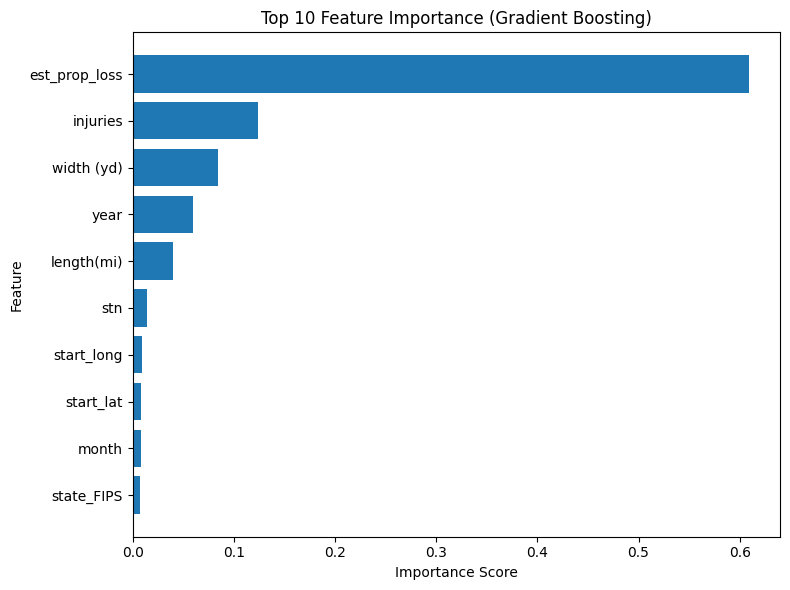

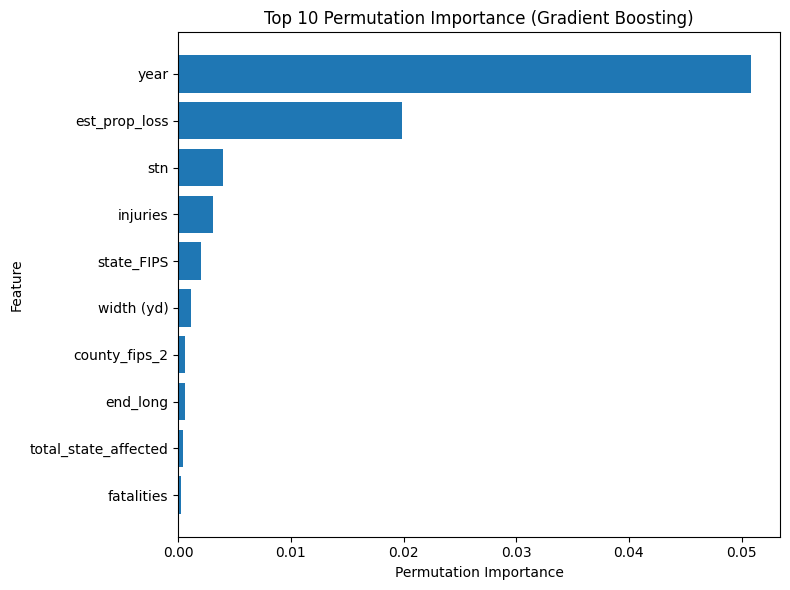

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

df = tornado_df
df_ranged = tornado_ranged_df
pred_items = ["violent_ranged"]
exclude_items = ["middle_ranged", "violent_ranged", "non_violent_ranged", "EF-Scale"];

# Merge Dataframes
df_ranged.index = df.index
df = pd.merge(df, df_ranged, left_index=True, right_index=True, how='left')

for i in range(len(pred_items)):

  # Confusion Matrix Labels
  labels = [[
      ['NonViolent', 'Violent'],
      ['NonViolent', 'Violent']
      ],
      [
      ['NonViolent', 'Violent'],
      ['NonViolent', 'Violent']
      ]]

  # Hyperparameters
  max_depth_range=range(5, 20)
  min_samples_split_range=[5, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

  # Get Test / Training Data
  X = df[get_numeric_columns(df, exclude_items)]
  y = df[pred_items[i]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Apply SMOTE to balance the dataset
  smote = SMOTE(random_state=42)
  X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

  #Heatmap
  #---------------------------------------------------------

  # Model Heatmap Results
  results = []

  # Decision Tree Classifier Model (Heatmap)
  for depth in max_depth_range:
      for min_split in min_samples_split_range:

          # Fit Decision Tree With Hyperparameters
          dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split)
          dtc.fit(X_train_balanced, y_train_balanced)

          # Calculate Predictions / Metrics
          y_pred = dtc.predict(X_test)
          y_pred_proba = dtc.predict_proba(X_test)[:, 1]
          accuracy = round(accuracy_score(y_test, y_pred), 4)
          auroc = round(roc_auc_score(y_test, y_pred_proba), 4)
          combined_score = 0.5 * accuracy + 0.5 * auroc

          # Save Results
          results.append({
              'max_depth': depth,
              'min_samples_split': min_split,
              'accuracy': accuracy,
              'auroc': auroc,
              'combined_score': combined_score
          })

  # Convert Results into Dataframe
  results_df = pd.DataFrame(results)

  # Pivot for accuracy
  accuracy_pivot = results_df.pivot(
      index='max_depth',
      columns='min_samples_split',
      values='accuracy'
  )

  # Pivot for AUROC
  auroc_pivot = results_df.pivot(
      index='max_depth',
      columns='min_samples_split',
      values='auroc'
  )

  # Pivot for Combined
  combined_pivot = results_df.pivot(
      index='max_depth',
      columns='min_samples_split',
      values='combined_score'
  )

  # Set up the figure with two subplots side by side
  plt.figure(figsize=(12, 6))

  # Plot heatmaps
  plt.figure(figsize=(18, 6))
  plt.subplot(1, 3, 1)
  sns.heatmap(accuracy_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
  plt.title('Accuracy Heatmap')
  plt.xlabel('Min Samples Split')
  plt.ylabel('Max Depth')

  plt.subplot(1, 3, 2)
  sns.heatmap(auroc_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
  plt.title('AUROC Heatmap')
  plt.xlabel('Min Samples Split')
  plt.ylabel('Max Depth')

  plt.subplot(1, 3, 3)
  sns.heatmap(combined_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
  plt.title('Combined Score (0.5 Acc + 0.5 AUROC)')
  plt.xlabel('Min Samples Split')
  plt.ylabel('Max Depth')

  # Display Heatmaps
  plt.tight_layout()
  plt.show()

  #---------------------------------------------------------

  # Best Performing Tree (Decision Tree / GradientBoosting)
  #---------------------------------------------------------
  from sklearn.inspection import permutation_importance
  from sklearn.ensemble import GradientBoostingClassifier

  # Best Performing Tree (Based on Combined Score)
  best_result = results_df.loc[results_df['combined_score'].idxmax()]  # Use combined score
  best_max_depth = int(best_result['max_depth'])
  best_min_samples_split = int(best_result['min_samples_split'])
  best_accuracy = best_result['accuracy']
  best_auroc = best_result['auroc']
  best_combined_score = best_result['combined_score']

  print(f"\nBest Performing Tree for {pred_items[i]} (Combined Score):")
  print(f"Max Depth: {best_max_depth}")
  print(f"Min Samples Split: {best_min_samples_split}")
  print(f"Accuracy: {best_accuracy}")
  print(f"AUROC: {best_auroc}")
  print(f"Combined Score: {best_combined_score:.4f}")

  # Best Decision Tree
  best_dtc = DecisionTreeClassifier(
      max_depth=int(best_max_depth),
      min_samples_split=int(best_min_samples_split),
      random_state=42
  )
  best_dtc.fit(X_train_balanced, y_train_balanced)
  y_pred_best = best_dtc.predict(X_test)

  # Build Confusion Matrix for Best Decision Tree
  build_pred_confusion_matrix(y_test, y_pred_best, labels[i][0])

  # Best Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(
      learning_rate=0.01,
      max_depth=best_max_depth,
      n_estimators=100,
      min_samples_split=best_min_samples_split,
      min_samples_leaf=1,
      random_state=42
  )
  gbc.fit(X_train_balanced, y_train_balanced)

  # Calculate Predictions / Metrics
  y_pred_best = gbc.predict(X_test)
  gbc_accuracy = accuracy_score(y_test, y_pred_best)
  gbc_auroc = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])

  # Show Metrics
  print(f"\nGradient Boosting Classifier Performance for {pred_items[i]}:")
  print(f"Accuracy: {gbc_accuracy:.4f}")
  print(f"AUROC: {gbc_auroc:.4f}")

  # Build Confusion Matrix for Best Gradient Boosting
  build_pred_confusion_matrix(y_test, y_pred_best, labels[i][1])

  # Feature Importance Plot for Best Gradient Boosting (Top 10)
  importances = gbc.feature_importances_
  feature_names = X_test.columns
  indices = np.argsort(importances)[::-1]  # Sort descending (largest first)
  top_10_indices = indices[:10]  # Take top 10 (most important)

  plt.figure(figsize=(8, 6))
  plt.barh(range(10), importances[top_10_indices], align="center")
  plt.yticks(range(10), np.array(feature_names)[top_10_indices])
  plt.gca().invert_yaxis()  # Largest on top
  plt.xlabel("Importance Score")
  plt.ylabel("Feature")
  plt.title("Top 10 Feature Importance (Gradient Boosting)")
  plt.tight_layout()
  plt.show()

  # Permutation Importance Plot for Best Gradient Boosting (Top 10)
  result = permutation_importance(gbc, X_test, y_test, n_repeats=10, random_state=42)
  indices_perm = np.argsort(result.importances_mean)[::-1]  # Sort descending (largest first)
  top_10_indices_perm = indices_perm[:10]  # Take top 10 (most important)

  plt.figure(figsize=(8, 6))
  plt.barh(range(10), result.importances_mean[top_10_indices_perm], align="center")
  plt.yticks(range(10), np.array(feature_names)[top_10_indices_perm])
  plt.gca().invert_yaxis()  # Largest on top
  plt.xlabel("Permutation Importance")
  plt.ylabel("Feature")
  plt.title("Top 10 Permutation Importance (Gradient Boosting)")
  plt.tight_layout()
  plt.show()
  plt.show()

  #---------------------------------------------------------

middle_ranged


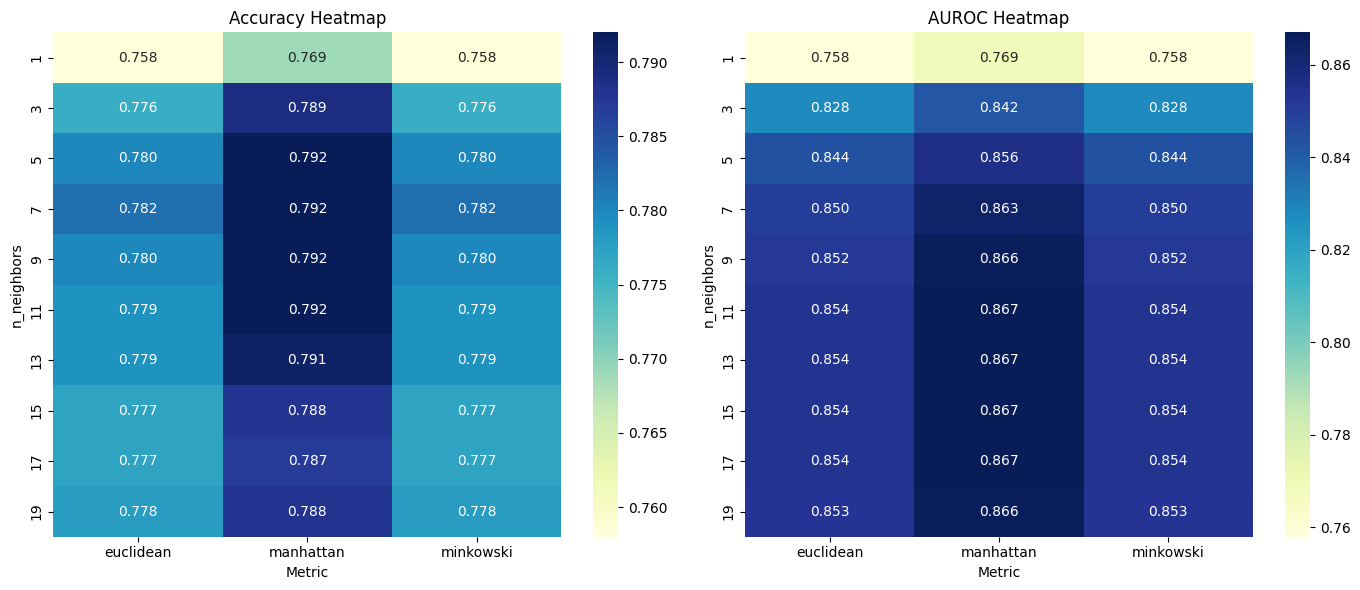


Best Hyperparameters:
n_neighbors: 5
metric: manhattan
Accuracy: 0.792
AUROC: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
# NEAREST NEIGHBORS WITH HYPERPARAMETERS

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

df = tornado_df
df_extra = tornado_df_extra

# Merge dataframes
df_extra.index = df.index
df = pd.merge(df, df_extra, left_index=True, right_index=True, how='left')

pred_items = [
    "middle_ranged"
]
exclude_items = [
    ["middle_ranged", "violent_ranged", "non_violent_ranged", "EF-Scale"]
];

for i in range(len(pred_items)):

  print(pred_items[i])

  X = df[get_numeric_columns(df, exclude_items[i])]
  y = df[pred_items[i]]

  # Training / Test Data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  data = (X_train, X_test, y_train, y_test)

  def train_knn_multible(
      data, # Training / Test Data
      n_neighbors_range=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19],  #Choices
      metric_options=['euclidean', 'manhattan', 'minkowski'], #Metrics
  ):
      results = []
      X_train, X_test, y_train, y_test = data

      for n_neighbors in n_neighbors_range:
          for metric in metric_options:
              # Model With Hyperparameters
              knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
              knn.fit(X_train, y_train)
              # Get Predictions
              y_pred = knn.predict(X_test)
              y_pred_proba = knn.predict_proba(X_test)[:, 1]
              # Calculate Metrics
              accuracy = round(accuracy_score(y_test, y_pred), 3)
              auroc = round(roc_auc_score(y_test, y_pred_proba), 3)
              # Save Results
              results.append({
                  'n_neighbors': n_neighbors,
                  'metric': metric,
                  'accuracy': accuracy,
                  'auroc': auroc
              })

      return (pd.DataFrame(results))

  #Build Heatmap and display Best Model
  def build_heatmap_w_best(results_df, data):
      # Pivot for accuracy
      accuracy_pivot = results_df.pivot(
          index='n_neighbors',
          columns='metric',
          values='accuracy'
      )

      # Pivot for AUROC
      auroc_pivot = results_df.pivot(
          index='n_neighbors',
          columns='metric',
          values='auroc'
      )

      # Set up the figure with two subplots side by side
      plt.figure(figsize=(14, 6))

      # Plot heatmap for accuracy
      plt.subplot(1, 2, 1)
      sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
      plt.title('Accuracy Heatmap')
      plt.xlabel('Metric')
      plt.ylabel('n_neighbors')

      # Plot heatmap for AUROC
      plt.subplot(1, 2, 2)
      sns.heatmap(auroc_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
      plt.title('AUROC Heatmap')
      plt.xlabel('Metric')
      plt.ylabel('n_neighbors')

      # Display Heatmaps
      plt.tight_layout()
      plt.show()

      # Best Hyperparameters
      best_result = results_df.loc[results_df['accuracy'].idxmax()]
      print("\nBest Hyperparameters:")
      print(f"n_neighbors: {best_result['n_neighbors']}")
      print(f"metric: {best_result['metric']}")
      print(f"Accuracy: {best_result['accuracy']}")
      print(f"AUROC: {best_result['auroc']}")

      data = (X_train, X_test, y_train, y_test)

      # Best Model
      best_knn = KNeighborsClassifier(n_neighbors=int(best_result['n_neighbors']), metric=best_result['metric'])
      best_knn.fit(X_train, y_train)
      y_pred_best = best_knn.predict(y_test)

      # Show Best Confusion Matrix
      visualize_predictions(y_test, y_pred_best, 'classification')

  results_df = train_knn_multible(data)
  build_heatmap_w_best(results_df, data)